## Preparing 2d-seismic and labels for `seismiqb`

In [221]:
# paths
PATH_TO_SEGY = '/notebooks/2d_seismic_fixed/segys/'
PATH_TO_HORIZONS = '/notebooks/2d_seismic_fixed/horizons/'
PATH_TO_H5 = '/notebooks/2d_seismic_h5/' # here we will store all of the coverted hdf5-cubes

* check out the header for a segy-file

In [211]:
import segyio
from segyio.tracefield import keys as trace_keys
from tqdm import tqdm_notebook
import numpy as np
import sys

In [212]:
path = PATH_TO_SEGY + '1118030018_invPol-22_uvz.segy'

In [209]:
file = segyio.open(path, strict=False)
num_samples = file.header[0].get(trace_keys['TRACE_SAMPLE_COUNT'])
num_traces = len(file.header)

In [210]:
file.header[0]

{TRACE_SEQUENCE_LINE: 1, TRACE_SEQUENCE_FILE: 1, FieldRecord: 1, TraceNumber: 1, EnergySourcePoint: 0, CDP: 0, CDP_TRACE: 1, TraceIdentificationCode: 1, NSummedTraces: 0, NStackedTraces: 0, DataUse: 1, offset: 0, ReceiverGroupElevation: 0, SourceSurfaceElevation: 0, SourceDepth: 0, ReceiverDatumElevation: 0, SourceDatumElevation: 0, SourceWaterDepth: 0, GroupWaterDepth: 0, ElevationScalar: 1, SourceGroupScalar: -1, SourceX: 1022597, SourceY: 6265916, GroupX: 0, GroupY: 0, CoordinateUnits: 1, WeatheringVelocity: 0, SubWeatheringVelocity: 0, SourceUpholeTime: 0, GroupUpholeTime: 0, SourceStaticCorrection: 0, GroupStaticCorrection: 0, TotalStaticApplied: 0, LagTimeA: -1000, LagTimeB: 0, DelayRecordingTime: -1000, MuteTimeStart: 0, MuteTimeEND: 0, TRACE_SAMPLE_COUNT: 2000, TRACE_SAMPLE_INTERVAL: 2000, GainType: 0, InstrumentGainConstant: 0, InstrumentInitialGain: 0, Correlated: 1, SweepFrequencyStart: 0, SweepFrequencyEnd: 0, SweepLength: 0, SweepType: 1, SweepTraceTaperLengthStart: 0, Swe

* We can see that `INLINE_3d` and `CROSSLINE_3D` keys are absent. So, `seismiqb` won't work with these files right of the bat. Let's check some more fields

In [176]:
num_samples

2000

In [177]:
num_traces

1463

In [178]:
file.header[1].get(trace_keys['CDP_X']) - file.header[0].get(trace_keys['CDP_X'])

25

In [179]:
file.header[2].get(trace_keys['CDP_X']) - file.header[1].get(trace_keys['CDP_X'])

25

In [180]:
file.header[3].get(trace_keys['CDP_X']) - file.header[2].get(trace_keys['CDP_X'])

25

* Ok. We can clearly see that `CDP`s can be well aligned into lines. Let's check out one segy

In [181]:
len(file.trace)

1463

In [182]:
len(file.trace[0])

2000

In [183]:
lst = []

In [184]:
for i in range(len(file.trace)):
    lst.append(file.trace[i])

In [185]:
data_ = np.array(lst)

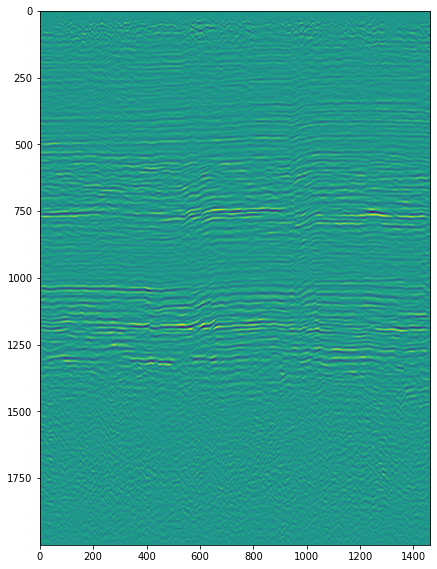

In [186]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(7, 10))
ax.imshow(data_.T)

* Ok. Looks good!

Let's write a converter from `segy` to `hdf5`-format. Each `segy` takes one iline and a set of xlines.

# Writing converter

* to begin with, let's check out what is occupied by segys

In [187]:
def get_cdps_from_segys(segyfiles_paths):
    """ Get cdp-coordinates for a set of segy-files: cdp_pair, cdp_xs, cdp_ys.
    """
    # get min-max cdp-values
    cdp_pairs, cdp_xs, cdp_ys = [], [], []
    for path in segyfiles_paths:
        with segyio.open(path, strict=False) as segyfile:
            for header in segyfile.header:
                cdp_x, cdp_y = header.get(segyio.TraceField.CDP_X), header.get(segyio.TraceField.CDP_Y)
                cdp_xs.append(cdp_x)
                cdp_ys.append(cdp_y)
                cdp_pairs.append((cdp_x, cdp_y))

    return cdp_pairs, cdp_xs, cdp_ys

In [188]:
def scatter_on_area(cdp_pairs, cdp_xs=None, cdp_ys=None, x_range=None, y_range=None, scale=10000):
    # make scaled rectangle
    if x_range is None or y_range is None:
        x_min, x_max = min(cdp_xs), max(cdp_xs)
        y_min, y_max = min(cdp_ys), max(cdp_ys)
    else:
        x_min, x_max = x_range
        y_min, y_max = y_range
    area = np.zeros(shape=[int((x_max - x_min) / scale + 1), int((y_max - y_min) / scale + 1)])

    # put pairs in prepared area
    for value in cdp_pairs:
        scaled_value = int((value[0] - x_min) / scale), int((value[1] - y_min) / scale)
        if 0 <= scaled_value[0] <= (x_max - x_min) / scale + 1 and 0 <= scaled_value[1] <= (y_max - y_min) / scale + 1:
            area[scaled_value] = 1
    
    return area

In [189]:
from glob import glob

In [213]:
cdp_pairs, cdp_xs, cdp_ys = get_cdps_from_segys(glob(PATH_TO_SEGY + '*.segy'))

In [214]:
len(glob(PATH_TO_SEGY + '*.segy'))

381

In [232]:
def show_scatter(pairs, x_range, y_range, figsize=(10, 15)):
    area = scatter_on_area(np.array(pairs), x_range=x_range, y_range=y_range, scale=300)
    fig, ax = plt.subplots(figsize=(10, 15))
    ax.imshow(area)
    plt.xlabel('ilines', fontdict={'fontsize': 14})
    plt.ylabel('xlines', fontdict={'fontsize': 14})
    plt.title('Scattered 2d-segys', fontdict={'fontsize': 18})

In [233]:
x_range = min(cdp_xs), max(cdp_xs)
y_range = min(cdp_ys), max(cdp_ys)

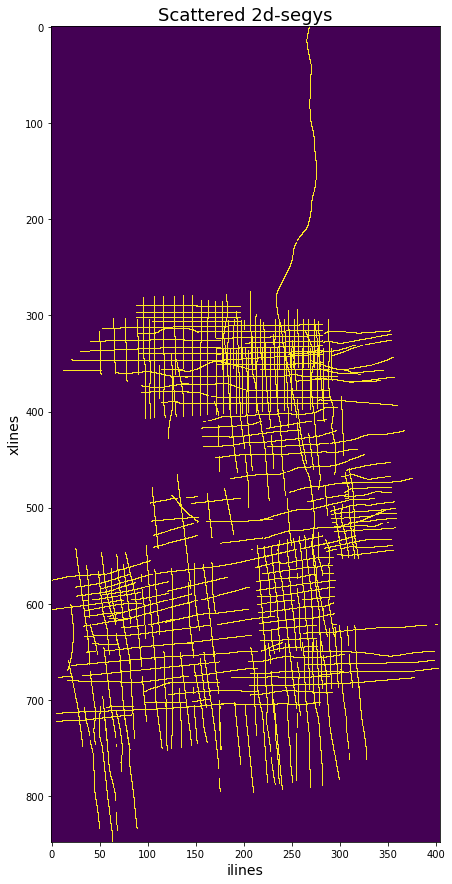

In [234]:
show_scatter(cdp_pairs, x_range, y_range)

* we can see that **a lot** of segys do not cover straight lines. Let's write a converter-func from `segy` to `h5`

In [219]:
import os
import h5py
import pickle

def convert_2d_segy_to_h5py(path_segy, path_h5py=None, postfix='', ilines_offset=0,
                            xlines_offset=0, dtype=np.float32, save_transform=True):
    """ Convert 2d-segy to h5py-format applicable for seismiqb.
    """
    with segyio.open(path_segy, strict=False) as segyfile:
        # read segy-attributes
        first_header = segyfile.header[0]
        depth = len(segyfile.trace[0])
        delay = first_header.get(segyio.TraceField.DelayRecordingTime)
        sample_rate = first_header.get(segyio.TraceField.TRACE_SAMPLE_INTERVAL) / 1000
        
        # the number of "xlines"
        xlines_len = len(segyfile.trace)

        # make h5-dataset
        path_h5py = path_h5py or (os.path.splitext(path_segy)[0] + postfix + '.hdf5')
        if os.path.exists(path_h5py):
            os.remove(path_h5py)

        h5py_file = h5py.File(path_h5py, "a")
        cube_h5py = h5py_file.create_dataset('cube', (1, xlines_len, depth))
        cube_h5py_x = h5py_file.create_dataset('cube_x', (xlines_len, depth, 1))
        cube_h5py_h = h5py_file.create_dataset('cube_h', (depth, 1, xlines_len))

        # fill in traces from 2d-segy into h5py-cube, make transformation dict
        with segyio.open(path_segy, 'r', strict=False) as segyfile:
            transform = dict()
            segyfile.mmap()

            description = 'Converting {} to h5py'.format('/'.join(path_segy.split('/')[-2:]))
            slide = np.zeros((xlines_len, depth))

            for i in range(xlines_len):
                trace = segyfile.trace[i]
                slide[i, :] = trace
                transform.update({(segyfile.header[i].get(segyio.TraceField.CDP_X),
                                   segyfile.header[i].get(segyio.TraceField.CDP_Y)):
                                  (ilines_offset, xlines_offset + i)})

            slide = slide.astype(dtype)
            cube_h5py[0, :, :] = slide

        # Save all the necessary attributes to the `info` group of the file
        attributes = ['depth', 'delay', 'sample_rate', 'value_min', 'value_max',
                      'ilines',
                      'xlines',
                      'zero_traces']
        for key, value in zip(attributes,
                              [depth, delay, sample_rate, np.min(slide), np.max(slide),
                               np.arange(ilines_offset, ilines_offset + 1),
                               np.arange(xlines_offset, xlines_offset + xlines_len),
                               ((np.max(slide, axis=1) - np.min(slide, axis=1)) == 0).astype(np.float32)]):
            h5py_file['/info/' + key] = value

        h5py_file.close()

        # dump transform dict if needed
        if save_transform:
            path_transform = os.path.splitext(path_h5py)[0] + postfix + '.tform'
            if os.path.exists(path_transform):
                os.remove(path_transform)

            with open(path_transform, 'wb') as file:
                pickle.dump(transform, file)

* convert all segys in a loop

In [169]:
for segypath in glob(PATH_TO_SEGY + '*.segy'):
    name = os.path.splitext(os.path.basename(segypath))[0]
    if not os.path.exists(PATH_TO_H5 + name):
        os.mkdir(PATH_TO_H5 + name)

    h5name = (PATH_TO_H5 + name + '/' + name + '.hdf5')
    convert_2d_segy_to_h5py(segypath, path_h5py=h5name)

## Working with labels

In [202]:
import pandas as pd
label_file = pd.read_csv(PATH_TO_HORIZONS + '2', delim_whitespace=True,
                         names=['textname', 'number', 'cdp_x', 'cdp_y', 'height', 'othername'],
                         skiprows=1)

In [203]:
label_file.head(3)

,textname,number,cdp_x,cdp_y,height,othername
0,Line_FXNAT3286003_LMK,947.0,919570.9325,6.304651e+06,2357.06470,Rename_Anon_OGM
1,Line_FXNAT3286003_LMK,948.0,919600.9000,6.304653e+06,2356.30225,Rename_Anon_OGM
2,Line_FXNAT3286003_LMK,949.0,919630.8675,6.304654e+06,2356.33521,Rename_Anon_OGM


* the first column corresponds to the name of segy-file. Each `.txt`-file with labels can cover several `segy`s: 

In [206]:
label_file.textname.unique()[:3]

array(['Line_FXNAT3286003_LMK', 'Line_FXNAT3286023_LMK',
       'Line_FXNAT114110030_LMK'], dtype=object)

* let's split each label-file on separate files for each `segy`

In [171]:
def split_labels(path_to_labels, path_to_h5=PATH_TO_H5): 
    hor_data = pd.read_csv(labels_path, delim_whitespace=True,
                           names=['textname', 'number', 'cdp_x', 'cdp_y', 'height', 'othername'],
                           skiprows=1)
    hor_name = os.path.basename(labels_path)

    # all segys for which the horizon is valid
    segynames = hor_data.textname.unique()
    for name in segynames:
        hor_sub = hor_data[hor_data.textname == name]
        
        # read trasnform-dict
        with open(path_to_h5 + name + '/' + name + '.tform', 'rb') as file:
            transform = pickle.load(file)

        # fill up list of converted pairs
        converted_pairs = []
        heights = hor_sub.height.values.reshape(-1, 1)
        for pair in hor_sub[['cdp_x', 'cdp_y']].values:
            ctr = 0
            il_xl = None
            #for i_, j_ in [(-1, -1), (-1, 0), (0, -1), (0, 0), (0, 1), (1, 1)]:
            for i_, j_ in [(0, 0)]:
                pair_ = (int(np.rint(pair[0])) + i_, int(np.rint(pair[1])) + j_)
                il_xl = transform.get(pair_)
                if il_xl is not None:
                    break
            if il_xl is not None:
                converted_pairs.append(il_xl)
            else:
                ctr += 1
                converted_pairs.append((np.nan, np.nan))

        converted_pairs = np.array(converted_pairs).reshape(-1, 2)
        labels_arr = np.concatenate([converted_pairs, heights], axis=1)
        labels = pd.DataFrame(data=labels_arr, columns=['iline', 'xline', 'height'])
        if not os.path.exists(path_to_h5 + name + '/' + 'horizons'):
            os.mkdir(path_to_h5 + name + '/' + 'horizons')
        labels.to_csv(path_to_h5 + name + '/' + 'horizons/' + hor_name + '.txt', sep=' ', index=False, header=False)

In [ ]:
for hor_path in glob(PATH_TO_HORIZONS + '*'):
    split_labels(hor_path)

* let's also check out how label-files cover the cube-area

In [30]:
import pandas as pd
def get_cdps_from_labels(paths):
    """ Get cdp-coordinates for a set of segy-files: cdp_pair, cdp_xs, cdp_ys.
    """
    # get min-max cdp-values
    cdp_pairs, cdp_xs, cdp_ys = [], [], []
    for path in paths:

        coords = pd.read_csv(path, delim_whitespace=True,
                             names=['textname', 'number', 'cdp_x',
                                    'cdp_y', 'height', 'othername'],
                             skiprows=1)[['cdp_x', 'cdp_y']].values
        cdp_pairs.extend(list(coords))
        cdp_xs.extend(list(coords[:, 0]))
        cdp_ys.extend(list(coords[:, 1]))

    return cdp_pairs, cdp_xs, cdp_ys

In [223]:
ps, xs, ys = get_cdps_from_labels(glob(PATH_TO_HORIZONS + '*'))

In [224]:
x_range

(807925, 1062124)

In [225]:
y_range

(6249283, 6370415)

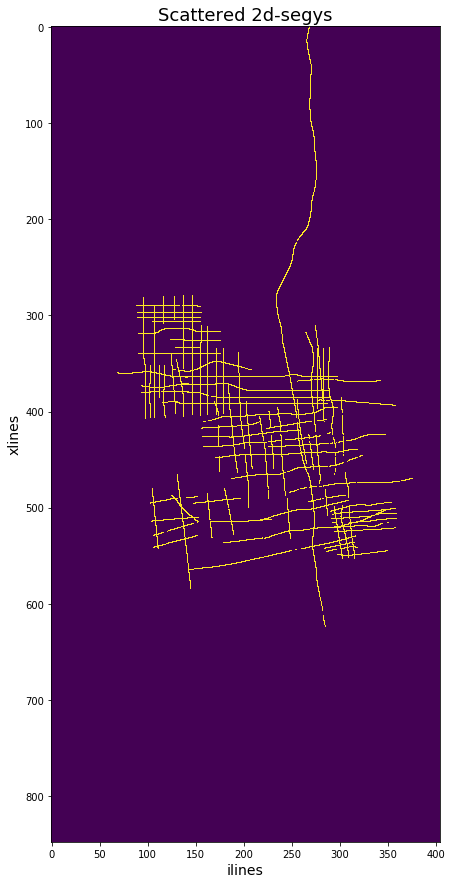

In [235]:
show_scatter(np.array(ps), x_range, y_range)

* Ok. We can see that the areas covered by horizons and segys have a strong overlap